## Exemplo de Rede DCN para Recomendação com MovieLens

Este exemplo demonstra como usar a rede DCN para construir um sistema de recomendação de filmes usando o conjunto de dados MovieLens.

**1. Preparações:**

* **Bibliotecas:** Importe as bibliotecas necessárias:

```python
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
```

* **Carregamento dos dados:**  Carregue o conjunto de dados MovieLens 100k:



* **Pré-processamento:**  Crie recursos para a rede:



**2. Construção da Rede DCN:**


**3. Treinamento e Avaliação:**



**4. Explicação do código:**

* O código usa duas entradas para IDs de usuário e item.
* As camadas de embedding transformam os IDs em vetores densos.
* A camada de cruzamento combina as embeddings de usuário e item usando multiplicação para capturar interações.
* As camadas densas e a função de ativação ReLU são usadas para extrair recursos.
* A camada de saída produz a probabilidade de interação entre usuário e item.
* O modelo é treinado usando dados de interação (classificações) e a perda de entropia cruzada.

**5. Melhorias:**

* **Regularização:** Adicionar regularização L2 (l2=0.001) às camadas densas para evitar overfitting.
* **Camadas de cruzamento:** Ajustar o número de iterações na camada de cruzamento para otimizar o desempenho.
* **Hiperparâmetros:** Ajuste a taxa de aprendizado, tamanho do lote e número de épocas para melhor desempenho.
* **Recursos adicionais:** Incluir mais recursos do MovieLens, como gênero de filme, classificação por idade, etc.

**6. Conclusão:**

Este exemplo demonstra como usar a rede DCN para construção de um sistema de recomendação de filmes com o MovieLens. A DCN pode capturar interações complexas entre usuários e itens, levando a resultados de recomendação mais precisos.

Lembre-se de que este é apenas um exemplo básico. Ajuste e otimize o modelo para o seu caso específico.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

ratings_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RECOMMENDER SYSTEMS/ml-100k/u.data', sep='\t', header=None, names=['userId', 'itemId', 'rating', 'timestamp'])
ratings_df['rating'] = ratings_df['rating'] >= 4  # Converter classificações em interações (0 ou 1)

In [13]:
# Adjust user and item IDs to start from 0
ratings_df['userId'] = ratings_df['userId'] - 1
ratings_df['itemId'] = ratings_df['itemId'] - 1

In [14]:
# Extrair IDs únicos de usuários e itens
num_users = ratings_df['userId'].nunique()
num_items = ratings_df['itemId'].nunique()

# Criar matrizes esparsas de interações de treinamento e teste
train_df, test_df = train_test_split(ratings_df, test_size=0.2)

# Criar matrizes de entrada para a rede DCN
train_users = train_df['userId'].values
train_items = train_df['itemId'].values
train_labels = train_df['rating'].values

test_users = test_df['userId'].values
test_items = test_df['itemId'].values
test_labels = test_df['rating'].values

In [15]:
# Camadas de entrada para IDs de usuário e item
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Camadas de embedding para usuários e itens
user_embedding = Embedding(num_users, 16, embeddings_initializer='uniform', name='user_embedding')(user_input)
item_embedding = Embedding(num_items, 16, embeddings_initializer='uniform', name='item_embedding')(item_input)

# Flatten para transformar embeddings em vetores
user_vec = Flatten(name='user_vec')(user_embedding)
item_vec = Flatten(name='item_vec')(item_embedding)

# Camada de cruzamento
cross_layer = Dense(32, activation='relu', name='cross_layer_0')(Concatenate()([user_vec, item_vec]))
# Changed initial layer name to be unique
for i in range(2):  # 2 iterações de cruzamento
    # Format a unique name for each cross layer within the loop
    cross_layer_name = f'cross_layer_{i+1}'
    cross_layer = Multiply()([cross_layer, Concatenate()([user_vec, item_vec])])
    # Apply the unique name to the Dense layer
    cross_layer = Dense(32, activation='relu', name=cross_layer_name)(cross_layer)

# Camada de combinação com embeddings
combined_features = Concatenate()([user_vec, item_vec, cross_layer])

# Camada de saída (probabilidade de interação)
output = Dense(1, activation='sigmoid', name='output')(combined_features)

# Criar o modelo
model = Model(inputs=[user_input, item_input], outputs=output)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['accuracy'])

# Imprimir a estrutura do modelo
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 16)          │         15,088 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 16)          │         26,912 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_vec (Flatten)        │ (None, 16)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_vec (Flatten)        │ (None, 16)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 32)             │              0 │ user_vec[0][0],        │
│ (Concatenate)             │                        │                │ item_vec[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cross_layer_0 (Dense)     │ (None, 32)             │          1,056 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 32)             │              0 │ user_vec[0][0],        │
│ (Concatenate)             │                        │                │ item_vec[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_5 (Multiply)     │ (None, 32)             │              0 │ cross_layer_0[0][0],   │
│                           │                        │                │ concatenate_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cross_layer_1 (Dense)     │ (None, 32)             │          1,056 │ multiply_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 32)             │              0 │ user_vec[0][0],        │
│ (Concatenate)             │                        │                │ item_vec[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 32)             │              0 │ cross_layer_1[0][0],   │
│                           │                        │                │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cross_layer_2 (Dense)     │ (None, 32)             │          1,056 │ multiply_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 64)             │              0 │ user_vec[0][0],        │
│ (Concatenate)             │                        │                │ item_vec[0][0],        │
│                           │                        │                │ cross_layer_2[0][0]    │
├──────────────────────

 Total params: 45,233 (176.69 KB)

 Trainable params: 45,233 (176.69 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Treinar o modelo
history = model.fit(
    x=[train_users, train_items],
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(x=[test_users, test_items], y=test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Fazer previsões
predictions = model.predict(x=[test_users, test_items])

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7863 - loss: 0.4358 - val_accuracy: 0.6979 - val_loss: 0.6537
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7951 - loss: 0.4195 - val_accuracy: 0.6964 - val_loss: 0.6853
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8035 - loss: 0.4079 - val_accuracy: 0.6920 - val_loss: 0.7132
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8147 - loss: 0.3871 - val_accuracy: 0.6923 - val_loss: 0.7731
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8245 - loss: 0.3698 - val_accuracy: 0.6862 - val_loss: 0.8156
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8316 - loss: 0.3577 - val_accuracy: 0.6840 - val_loss: 0.8822
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8404 - loss: 0.3421 - val_accuracy: 0.6793 - val_loss: 0.9135
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8491 - loss: 0.3259 -

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6807 - loss: 1.1483
Loss: 1.1147961616516113, Accuracy: 0.6758000254631042


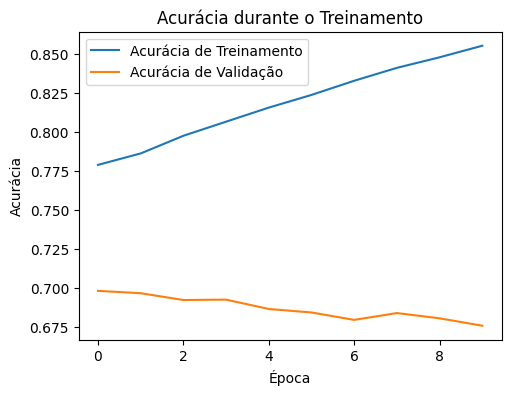

In [19]:
# Avaliar o modelo no conjunto de teste
import matplotlib.pyplot as plt
loss, accuracy = model.evaluate(x=[test_users, test_items], y=test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plotar os gráficos
plt.figure(figsize=(12, 4))

# Plotar a acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()